In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops
import math
import matplotlib.pyplot as plt
import time
import random

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Read Files and Data Preprocessing

In [2]:
xtrain = open('xtrain_obfuscated.txt', 'r').read().split('\n')[:-1]
xtest = open('xtest_obfuscated.txt', 'r').read().split('\n')[:-1]
ytrain = open('ytrain.txt', 'r').read().split('\n')[:-1]

In [3]:
data = open('xtrain_obfuscated.txt', 'r').read()
chars = list(set(data))
vocab_size = len(chars)
print('There are %d unique characters in your data.' % (vocab_size))

There are 27 unique characters in your data.


In [4]:
char_to_ix = { ch:i for i,ch in enumerate(sorted(chars)) }
print(char_to_ix)

{'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [5]:
max_seq_length = max([len(i) for i in xtrain])
print('The maximum length of string in your dataset is %d' % (max_seq_length))

The maximum length of string in your dataset is 452


In [6]:
for i in range(0,12):
    print('number of value ' + str(i) + ':' + str(ytrain.count(str(i))))

number of value 0:543
number of value 1:3459
number of value 2:1471
number of value 3:4023
number of value 4:2337
number of value 5:2283
number of value 6:4226
number of value 7:5097
number of value 8:3634
number of value 9:980
number of value 10:3052
number of value 11:1408


In [7]:
def sampling(category, training_size, testing_size):
    x_train_sub = []
    y_train_sub = []
    x_valid_sub = []
    y_valid_sub = []

    index = [pos for pos, value in enumerate(ytrain) if value == str(category)]
    number = len(index)
    train_size = round(number * 0.9)

    train_idx = random.sample(index, train_size)
    valid_idx = [ele for ele in index if ele not in train_idx]
 

    if (number < (training_size + testing_size)):
    
        x_train_sub = x_train_sub + [value for pos, value in enumerate(xtrain) if pos in train_idx]
        x_valid_sub = x_valid_sub + [value for pos, value in enumerate(xtrain) if pos in valid_idx]
    
        num_of_increase_training = training_size - len(train_idx)
    
        for i in range(0, num_of_increase_training):
            sample_idx = random.sample(train_idx, 1)[0]
            sample = xtrain[sample_idx]
    
            start_point = random.sample(range(0, int(len(sample)/2)), 1)[0]
            end_point = random.sample(range(start_point + int(len(sample)/2), len(sample)), 1)[0]
            new_sample = [sample[start_point: end_point]]
            x_train_sub = x_train_sub + new_sample
        
        num_of_increase_valid = testing_size - len(valid_idx)
    
        for i in range(0, num_of_increase_valid):
            sample_idx = random.sample(valid_idx, 1)[0]
            sample = xtrain[sample_idx]
    
            start_point = random.sample(range(0, int(len(sample)/2)), 1)[0]
            end_point = random.sample(range(start_point + int(len(sample)/2), len(sample)), 1)[0]
            new_sample = [sample[start_point: end_point]]
            x_valid_sub = x_valid_sub + new_sample    

    else:
        train_idx = random.sample(train_idx, training_size)
        valid_idx = random.sample(valid_idx, testing_size)
    
        x_train_sub = x_train_sub + [value for pos, value in enumerate(xtrain) if pos in train_idx]
        x_valid_sub = x_valid_sub + [value for pos, value in enumerate(xtrain) if pos in valid_idx] 

    
    y_train_sub = [category for i in range(0, training_size)]
    y_valid_sub = [category for i in range(0, testing_size)]
    
    return x_train_sub, x_valid_sub, y_train_sub, y_valid_sub
    


In [8]:
training_size = 4500
testing_size = 500
x_train = []
x_valid = []
y_train = []
y_valid = []

for category in range(0,12):
    x_train_sub, x_valid_sub, y_train_sub, y_valid_sub = sampling(category, training_size, testing_size)
    x_train = x_train + x_train_sub
    x_valid = x_valid + x_valid_sub
    y_train = y_train + y_train_sub
    y_valid = y_valid + y_valid_sub

In [9]:
print("number of samples in x_train:" + str(len(x_train)))
print("number of samples in x_valid:" + str(len(x_valid)))
print("number of samples in y_train:" + str(len(y_train)))
print("number of samples in y_valid:" + str(len(y_valid)))


number of samples in x_train:54000
number of samples in x_valid:6000
number of samples in y_train:54000
number of samples in y_valid:6000


In [10]:
def X_one_hot(data, vocab, seq_length):
    
    X_train = np.zeros(shape=[len(data), seq_length, len(vocab), 1])
    
    for i in range(0, len(data)):
        ith_seq = data[i]

        if (len(ith_seq) < seq_length):
            ith_seq = ith_seq + ('\n' * (seq_length - len(ith_seq)))
        else:
            ith_seq = ith_seq[0:(seq_length-1)]
        
        for j in range(0, len(ith_seq)):
            X_train[i][j][char_to_ix[ith_seq[j]]][0] = 1
    
    return X_train

In [11]:
def y_one_hot(labels, num_of_classes):
    
    num_of_classes = tf.constant(num_of_classes, name='num_of_classes')
    one_hot_matrix = tf.one_hot(indices=labels, depth=num_of_classes, axis=0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    
    return one_hot

In [12]:
X_train = X_one_hot(x_train, chars, max_seq_length)
X_valid = X_one_hot(x_valid, chars, max_seq_length)
X_test = X_one_hot(xtest, chars, max_seq_length)

y_train = y_one_hot(y_train, num_of_classes = 12).T
y_valid = y_one_hot(y_valid, num_of_classes = 12).T


print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_validation shape: " + str(X_valid.shape))
print ("y_validation shape: " + str(y_valid.shape))
print ("X_test shape: " + str(X_test.shape))

number of training examples = 54000
number of test examples = 3000
X_train shape: (54000, 452, 27, 1)
y_train shape: (54000, 12)
X_validation shape: (6000, 452, 27, 1)
y_validation shape: (6000, 12)
X_test shape: (3000, 452, 27, 1)


## Create Placeholder

In [13]:
def create_placeholders(n_H0, n_W0, n_y):

    X = tf.placeholder(tf.float32, shape = [None, n_H0, n_W0, 1], name = 'input_x')
    Y = tf.placeholder(tf.float32, [None, n_y], name = 'input_y')
    dropout_keep_prob = tf.placeholder(tf.float32, name = 'dropout_keep_prob')
    
    return X, Y, dropout_keep_prob

In [14]:
X, Y, dropout_keep_prob = create_placeholders(max_seq_length, vocab_size,n_y = 12)
print ("X = " + str(X))
print ("Y = " + str(Y))
print ("Dropout_keep_prob = " + str(dropout_keep_prob))

X = Tensor("input_x:0", shape=(?, 452, 27, 1), dtype=float32)
Y = Tensor("input_y:0", shape=(?, 12), dtype=float32)
Dropout_keep_prob = Tensor("dropout_keep_prob:0", dtype=float32)


## Forward Propagation

In [15]:
def forward_propagation(X, n_y, dropout_keep_prob):
    conv_layers = [
                    [256, 7, 3],
                    #[256, 7, 3],
                    #[256, 3, None],
                    #[256, 3, None],
                    [256, 3, None],
                    [256, 3, 3]]
                    

    #fully_layers = [1024, 1024]
    fully_layers = [1024]
    
    var_id = 0
    
    parameters = {}
    
    for i, cl in enumerate(conv_layers):
        var_id += 1 
        filter_width = X.get_shape()[2].value
        filter_shape = [cl[1], filter_width, 1, cl[0]] # Perform 1D conv with [kw, inputFrameSize (i.e alphabet_size), outputFrameSize]
                # Convolution layer
        stdv = 1/np.sqrt(cl[0]*cl[1])
        W = tf.Variable(tf.random_uniform(filter_shape, minval=-stdv, maxval=stdv), dtype='float32', name='W'+ str(var_id) ) # The kernel of the conv layer is a trainable vraiable
        b = tf.Variable(tf.random_uniform(shape=[cl[0]], minval=-stdv, maxval=stdv), name = 'b' + str(var_id)) # and the biases as well
        parameters['W' + str(var_id)] = W
        parameters['b' + str(var_id)] = b

        conv = tf.nn.conv2d(X, W, [1, 1, 1, 1], "VALID", name = "Conv") # Perform the convolution operation

        X = tf.nn.bias_add(conv, b)

        if not cl[-1] is None:
            pool = tf.nn.max_pool(X, ksize=[1, cl[-1], 1, 1], strides=[1, cl[-1], 1, 1], padding='VALID')
            X = tf.transpose(pool, [0, 1, 3, 2]) # [batch_size, img_width, img_height, 1]
        else:
            X = tf.transpose(X, [0, 1, 3, 2], name='tr%d' % var_id) # [batch_size, img_width, img_height, 1]

    vec_dim = X.get_shape()[1].value * X.get_shape()[2].value
    X = tf.reshape(X, [-1, vec_dim])
    weights = [vec_dim] + list(fully_layers)
    
    for i, fl in enumerate(fully_layers):
        var_id += 1
        stdv = 1/np.sqrt(weights[i])
        W = tf.Variable(tf.random_uniform([weights[i], fl], minval=-stdv, maxval=stdv), dtype='float32', name='W')
        b = tf.Variable(tf.random_uniform(shape=[fl], minval=-stdv, maxval=stdv), dtype='float32', name = 'b')
        parameters['W' + str(var_id)] = W
        parameters['b' + str(var_id)] = b
                
        X = tf.nn.xw_plus_b(X, W, b)
        X = tf.nn.dropout(X, dropout_keep_prob)
    
    stdv = 1/np.sqrt(weights[-1])
    W = tf.Variable(tf.random_uniform([weights[-1], n_y], minval=-stdv, maxval=stdv), dtype='float32', name='W')
    b = tf.Variable(tf.random_uniform(shape=[n_y], minval=-stdv, maxval=stdv), name = 'b')
    parameters['W' + str(var_id + 1)] = W
    parameters['b' + str(var_id + 1)] = b
    p_y_given_x = tf.nn.xw_plus_b(X, W, b, name="scores")
        
    return p_y_given_x, parameters

In [16]:
#tf.reset_default_graph()

with tf.Session() as sess:
    X, Y, dropout_keep_prob = create_placeholders(max_seq_length, vocab_size,n_y = 12)
    p_y_given_x = forward_propagation(X, 12, dropout_keep_prob)
    sess.run(tf.global_variables_initializer())
    res1, res2 = sess.run(p_y_given_x, {X: np.random.randn(2,452,27,1), dropout_keep_prob:0.5})
    print("p_y_given_x = " + str(res1))
    #print(res2)


p_y_given_x = [[ 0.0241223   0.02751884 -0.01611185  0.0312215  -0.09325986 -0.0704421
  -0.00981938  0.03025233  0.01550109 -0.00709374 -0.03389454  0.0571539 ]
 [-0.03218047 -0.00753319  0.06038624  0.01163254 -0.04228123 -0.07713233
  -0.08065082  0.01224003  0.00050247 -0.03238136 -0.00233207  0.00563744]]


## Compute Cost

In [17]:
def compute_cost(X, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=X, labels=Y))
    
    return cost

In [18]:
#tf.reset_default_graph()

with tf.Session() as sess:
    X, Y, dropout_keep_prob = create_placeholders(max_seq_length, vocab_size,n_y = 12)
    p_y_given_x, parameters = forward_propagation(X, 12, dropout_keep_prob)
    cost = compute_cost(p_y_given_x, Y)
    sess.run(tf.global_variables_initializer())
    res2 = sess.run(cost, {X: np.random.randn(2,452,27,1), dropout_keep_prob:0.5, Y: np.random.randint(0, 11, size = (2,12))})
    print("cost = " + str(res2))
    #print("p_y_given_x = " + str(res1))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

cost = 135.08829


## Model

In [19]:
def random_mini_batches(X, Y, mini_batch_size):

    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:(k + 1) * mini_batch_size, :]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:, :]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [20]:
mini_batches = random_mini_batches(X_train, y_train, 64)

print("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
#print("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (64, 452, 27, 1)
shape of the 2nd mini_batch_X: (64, 452, 27, 1)
shape of the 3rd mini_batch_X: (64, 452, 27, 1)
shape of the 1st mini_batch_Y: (64, 12)
shape of the 2nd mini_batch_Y: (64, 12)
shape of the 3rd mini_batch_Y: (64, 12)


In [21]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
          num_epochs=120, minibatch_size=1024, print_cost=True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []    # To keep track of the cost
    conv_layers = [
                    [256, 7, 3],
                    #[256, 7, 3],
                    #[256, 3, None],
                    #[256, 3, None],
                    [256, 3, None],
                    [256, 3, 3]
                    ]

    #fully_layers = [1024, 1024]
    fully_layers = [1024]
    # Create Placeholders of the correct shape
    X, Y, dropout_keep_prob = create_placeholders(n_H0, n_W0, n_y)

    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    p_y_given_x, parameters = forward_propagation(X, n_y, dropout_keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(p_y_given_x, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set

            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y,dropout_keep_prob:[0.5]})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
            if minibatch_cost < 0.01:
                break
                
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        predict_op = tf.argmax(p_y_given_x, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, dropout_keep_prob: 0.5})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test, dropout_keep_prob: 0.5})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 2.395649
Cost after epoch 5: 1.934077
Cost after epoch 10: 1.564151
Cost after epoch 15: 1.311741
Cost after epoch 20: 1.148098
Cost after epoch 25: 1.034505
Cost after epoch 30: 0.963972
Cost after epoch 35: 0.874187
Cost after epoch 40: 0.814019
Cost after epoch 45: 0.728223
Cost after epoch 50: 0.665857
Cost after epoch 55: 0.598085
Cost after epoch 60: 0.560371
Cost after epoch 65: 0.499431
Cost after epoch 70: 0.440366
Cost after epoch 75: 0.393922
Cost after epoch 80: 0.334368
Cost after epoch 85: 0.305104
Cost after epoch 90: 0.251217
Cost after epoch 95: 0.238834
Cost after epoch 100: 0.183443
Cost after epoch 105: 0.138311
Cost after epoch 110: 0.132377
Cost after epoch 115: 0.089772


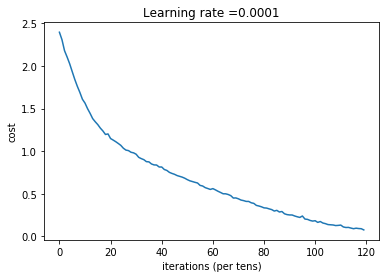

Parameters have been trained!
Train Accuracy: 0.99288887
Test Accuracy: 0.668
Time used: 23876.034982833804


In [22]:
start = time.clock()
_, _, parameters = model(X_train, y_train, X_valid, y_valid)
elapsed = (time.clock() - start)
print("Time used:",elapsed)

In [23]:
def forward_propagation_for_predict(X, parameters, dropout_keep_prob):

    conv_layers = [
                    [256, 7, 3],
                    #[256, 7, 3],
                    #[256, 3, None],
                    #[256, 3, None],
                    [256, 3, None],
                    [256, 3, 3]]
                    

    #fully_layers = [1024, 1024]
    fully_layers = [1024]

    #params = {}
    
    #for key in parameters.keys():
        #params[key] = tf.convert_to_tensor(parameters[key])
    
    var_id = 0
        
    for i, cl in enumerate(conv_layers):
        var_id += 1

        W = parameters["W" + str(var_id)]
        b = parameters["b" + str(var_id)]

        conv = tf.nn.conv2d(X, W, [1, 1, 1, 1], "VALID", name = "Conv") # Perform the convolution operation

        X = tf.nn.bias_add(conv, b)

        if not cl[-1] is None:
            pool = tf.nn.max_pool(X, ksize=[1, cl[-1], 1, 1], strides=[1, cl[-1], 1, 1], padding='VALID')
            X = tf.transpose(pool, [0, 1, 3, 2]) # [batch_size, img_width, img_height, 1]
        else:
            X = tf.transpose(X, [0, 1, 3, 2], name='tr%d' % var_id) # [batch_size, img_width, img_height, 1]

    vec_dim = X.get_shape()[1].value * X.get_shape()[2].value
    X = tf.reshape(X, [-1, vec_dim])
    weights = [vec_dim] + list(fully_layers)
    
    for i, fl in enumerate(fully_layers):
        var_id += 1

        W = parameters["W" + str(var_id)]
        b = parameters["b" + str(var_id)]
                
        X = tf.nn.xw_plus_b(X, W, b)
        X = tf.nn.dropout(X, dropout_keep_prob)
    
    W = parameters["W" + str(var_id + 1)]
    b = parameters["b" + str(var_id + 1)]


    p_y_given_x = tf.nn.xw_plus_b(X, W, b, name="scores")  
    
    return p_y_given_x

In [24]:
def predict(X, parameters):
    
    params = {}
    
    for key in parameters.keys():
        params[key] = tf.convert_to_tensor(parameters[key])

        
    x = tf.placeholder(tf.float32, shape = [None, 452, 27, 1], name = 'input_x')
    dropout_keep_prob = tf.placeholder(tf.float32, name = 'dropout_keep_prob')      

    predictions = forward_propagation_for_predict(x, params, dropout_keep_prob)

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        predictions = sess.run(predictions, feed_dict = {x: X, dropout_keep_prob:0.5})
        predicted_value = tf.argmax(predictions,1)
    
    
    return predicted_value

In [25]:
predicted_value = predict(X_test, parameters)


In [26]:

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables()) #execute init_op
    #print the random values that we sample
    res = sess.run(predicted_value)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [27]:
np.savetxt('ytest_v10.txt', res, fmt='%.1d')